In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import warnings
"""Make this none if env vars problem fixed"""
platform = "local"
#platform = "cluster"
#platform = "none"
if(platform=="local"):
    sys.path.append('/home/matthias/ETH/Thesis/VariTexLocal/VariTex/')
    %set_env OP=/home/matthias/ETH/Thesis/VariTexLocal/VariTex/outputFolder/
    %set_env FP=/home/matthias/ETH/Thesis/VariTexLocal/datasets/
    %set_env DP=/home/matthias/ETH/Thesis/Data/
    %set_env CP=/home/matthias/ETH/Thesis/VariTexLocal/VariTex/pretrained/ep44.ckpt
elif(platform=="cluster"):
    %set_env OP=/cluster/project/infk/hilliges/koenigma/VariTex/outputFolder/
    %set_env FP=/cluster/project/infk/hilliges/koenigma/VariTex/
    %set_env DP=/cluster/work/hilliges/shared/face_datasets/
    %set_env CP=/cluster/project/infk/hilliges/koenigma/VariTex/pretrained/ep44.ckpt
    sys.path.append('/cluster/project/infk/hilliges/koenigma/VariTex/')
warnings.filterwarnings('ignore')
import pytorch_lightning as pl
import torch
import numpy as np
from varitex.data.keys_enum import DataItemKey as DIK
pl.seed_everything(1234)
from mutil.object_dict import ObjectDict
from torch.utils.data import DataLoader
import argparse
from matplotlib import pyplot as pltc
from tqdm import tqdm



opt = {
        "checkpoint": os.path.join(os.getenv("CP", "pretrained/ep44.ckpt")),
        "dataroot_npy": os.path.join(os.getenv("DP", ""), 'FFHQ/preprocessed_dataset'),
        "path_bfm": os.path.join(os.getenv("FP", ""), "basel_facemodel/model2017-1_face12_nomouth.h5"),
        "path_uv": os.path.join(os.getenv("FP", ""), "basel_facemodel/face12.json"),
        "device": "cuda"
        }

path_latent = os.path.join(os.getenv("DP", ""), "FFHQ/preprocessed_dataset/latents.npy")

# from varitex.demo import Demo
# demo = Demo(opt)

env: OP=/home/matthias/ETH/Thesis/VariTexLocal/VariTex/outputFolder/
env: FP=/home/matthias/ETH/Thesis/VariTexLocal/datasets/
env: DP=/home/matthias/ETH/Thesis/Data/
env: CP=/home/matthias/ETH/Thesis/VariTexLocal/VariTex/pretrained/ep44.ckpt


Global seed set to 1234


In [3]:
import imageio
import torch

In [2]:
try:
    from mutil.object_dict import ObjectDict
    from varitex.data.keys_enum import DataItemKey as DIK
    #from varitex.data.uv_factory import BFMUVFactory
    #from varitex.modules.pipeline import PipelineModule
    #from varitex.visualization.batch import CompleteVisualizer
    from varitex.data.npy_dataset import NPYDataset
    #from varitex.options import varitex_default_options
    from varitex.options.train_options import TrainOptions
    from varitex.options.base_options import BaseOptions
except ModuleNotFoundError:
    print("Have you added VariTex to your pythonpath?")
    print('To fix this error, go to the root path of the repository ".../VariTex/" \n '
          'and run \n'
          "export PYTHONPATH=$PYTHONPATH:$(pwd)")
    exit()

ImportError: /home/matthias/miniconda3/envs/varitex/lib/python3.8/site-packages/pytorch3d/_C.cpython-38-x86_64-linux-gnu.so: undefined symbol: _ZNK2at6Tensor7is_cudaEv

In [57]:
myOpt= varitex_default_options()
additionalOpt = {
    'transform_mode': 'all',
    'image_folder': 'FFHQ/images',
    'dataroot_npy': os.path.join(os.getenv("DP"), 'FFHQ/preprocessed_dataset'),
    'batch_size': 7,
    'num_workers': 1
}
print(additionalOpt)
myOpt.update(additionalOpt)
default_opt = ObjectDict(myOpt)

{'transform_mode': 'all', 'image_folder': 'FFHQ/images', 'dataroot_npy': '/home/matthias/ETH/Thesis/Data/FFHQ/preprocessed_dataset', 'batch_size': 7, 'num_workers': 1}


In [59]:
dataset = NPYDataset(default_opt, split="all", augmentation=True)
dataloader = DataLoader(dataset, batch_size=default_opt.batch_size, num_workers=default_opt.num_workers, shuffle=True)

In [3]:

n_pca = 100#24576#(64 * 64 * 3 * 2)

In [68]:
X_pca = np.vstack([
            X.cpu().numpy().reshape(len(X), -1)
            for i, (X, _, _)
             in zip(tqdm(range(n_pca // dataloader.batch_size), 'collect data for PCA'), 
                    dataloader)
        ])


collect data for PCA:   0%|          | 0/14 [00:00<?, ?it/s]

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/matthias/miniconda3/envs/varitex/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/matthias/miniconda3/envs/varitex/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/matthias/miniconda3/envs/varitex/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/matthias/ETH/Thesis/VariTexLocal/VariTex/varitex/data/npy_dataset.py", line 182, in __getitem__
    image_raw = self._read_image(filename, (self.initial_width, self.initial_height))
  File "/home/matthias/ETH/Thesis/VariTexLocal/VariTex/varitex/data/npy_dataset.py", line 165, in _read_image
    raise FileNotFoundError("This image has not been found: '{}'".format(path_image))
FileNotFoundError: This image has not been found: 'FFHQ/images/68065.png'


In [15]:
default_opt = ObjectDict(varitex_default_options())

/home/matthias/ETH/Thesis/Data/FFHQ/preprocessed_dataset/images.npy
(70000, 256, 256, 3)


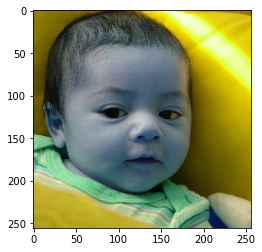

In [4]:
image_path  = os.path.join(opt["dataroot_npy"],"images.npy")
print(image_path)
images = np.load(image_path, mmap_mode='r')
print(images.shape)
image1 = images[0]
inMemImages = images[:100]
plt.imshow(inMemImages[0])

In [15]:
print((subimages).size)

19660800


In [26]:
im1 = subimages[1]
print((im1).shape)
print((im1).size)
print(len(im1))

(256, 256, 3)
196608
256


In [28]:
subimages = np.array(images[:100])
print(subimages.shape)
images_pca = np.vstack([x.reshape(((x).size)) for x in subimages])
print(images_pca.shape)

(100, 256, 256, 3)
(100, 196608)


In [7]:
print(np.vstack([subimages]).shape)

KeyboardInterrupt: 

In [ ]:
def stackfromnpy(npyfile, n_pca):
    x = np.load(npyfile)[:n_pca]
    images_pca = np.vstack([x.reshape(((x).size)) for x in subimages])

In [18]:
image1 = np.array(image1)
print(image1.shape)
print((image1.size))

(256, 256, 3)
196608


In [23]:
print(len(image1.reshape(image1.size,-1)))

196608


In [30]:
testImages = images[:100]
print(testImages.shape)
reshapedImages = testImages.reshape(testImages.shape[0], testImages[0].size)
print(reshapedImages.shape)

(100, 256, 256, 3)
(100, 196608)


In [36]:
pca = PCA(n_components=10)
d=pca.fit_transform(reshapedImages)

In [39]:
print(d.shape)

(100, 10)


In [4]:
def fit_pca_in_dataloader(dataLoader, target_dir, n_pca, latent_dim):
    X_pca = np.vstack([
            X.cpu().numpy().reshape(len(X), -1)
            for i, (X, _)
             in zip(tqdm(range(n_pca // dataLoader.batch_size), 'collect data for PCA'), 
                    dataLoader)
        ])
    pca = PCA(n_components=latent_dim)
    pca.fit(X_pca)
    Z = np.empty((len(dataLoader.dataset), latent_dim))
    for X, idx in tqdm(dataLoader, 'pca projection'):
        Z[idx] = pca.transform(X.cpu().numpy().reshape(len(X), -1))
    np.save(target_dir, Z)

def fit_pca_in_npy_file(source_file, target_dir, n_pca, latent_dim):
    images = np.load(source_file, mmap_mode='r')
    images_pca = np.vstack([x.reshape(((x).size)) for x in images[:n_pca]])
    pca = PCA(n_components=latent_dim)
    pca.fit(images_pca)
    Z = np.empty((len(images), latent_dim))
    for idx, X in tqdm(zip(range(len(images)), images), 'pca projection', total=len(images)):
        Z[idx] = pca.transform(X.reshape(1,(X).size))
    np.save(target_dir, Z)
    

In [ ]:
source_file = os.path.join(opt["dataroot_npy"],"images.npy")
target_dir = 'latentcodes.npy'
n_pca=10000
latent_code=10
fit_pca_in_npy_file(source_file, target_dir, n_pca, latent_code)

In [38]:
for i in ():
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638


9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294
9295
9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308
9309
9310
9311
9312
9313
9314
9315
9316
9317
9318
9319
9320
9321
9322
9323
9324
9325
9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338
9339
9340
9341
9342
9343
9344
9345
9346
9347
9348
9349
9350
9351
9352
9353
9354
9355
9356


13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
1326

17492
17493
17494
17495
17496
17497
17498
17499
17500
17501
17502
17503
17504
17505
17506
17507
17508
17509
17510
17511
17512
17513
17514
17515
17516
17517
17518
17519
17520
17521
17522
17523
17524
17525
17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537
17538
17539
17540
17541
17542
17543
17544
17545
17546
17547
17548
17549
17550
17551
17552
17553
17554
17555
17556
17557
17558
17559
17560
17561
17562
17563
17564
17565
17566
17567
17568
17569
17570
17571
17572
17573
17574
17575
17576
17577
17578
17579
17580
17581
17582
17583
17584
17585
17586
17587
17588
17589
17590
17591
17592
17593
17594
17595
17596
17597
17598
17599
17600
17601
17602
17603
17604
17605
17606
17607
17608
17609
17610
17611
17612
17613
17614
17615
17616
17617
17618
17619
17620
17621
17622
17623
17624
17625
17626
17627
17628
17629
17630
17631
17632
17633
17634
17635
17636
17637
17638
17639
17640
17641
17642
17643
17644
17645
17646
17647
17648
17649
17650
17651
17652
17653
17654
17655
17656
17657
1765

21630
21631
21632
21633
21634
21635
21636
21637
21638
21639
21640
21641
21642
21643
21644
21645
21646
21647
21648
21649
21650
21651
21652
21653
21654
21655
21656
21657
21658
21659
21660
21661
21662
21663
21664
21665
21666
21667
21668
21669
21670
21671
21672
21673
21674
21675
21676
21677
21678
21679
21680
21681
21682
21683
21684
21685
21686
21687
21688
21689
21690
21691
21692
21693
21694
21695
21696
21697
21698
21699
21700
21701
21702
21703
21704
21705
21706
21707
21708
21709
21710
21711
21712
21713
21714
21715
21716
21717
21718
21719
21720
21721
21722
21723
21724
21725
21726
21727
21728
21729
21730
21731
21732
21733
21734
21735
21736
21737
21738
21739
21740
21741
21742
21743
21744
21745
21746
21747
21748
21749
21750
21751
21752
21753
21754
21755
21756
21757
21758
21759
21760
21761
21762
21763
21764
21765
21766
21767
21768
21769
21770
21771
21772
21773
21774
21775
21776
21777
21778
21779
21780
21781
21782
21783
21784
21785
21786
21787
21788
21789
21790
21791
21792
21793
21794
21795
2179

25674
25675
25676
25677
25678
25679
25680
25681
25682
25683
25684
25685
25686
25687
25688
25689
25690
25691
25692
25693
25694
25695
25696
25697
25698
25699
25700
25701
25702
25703
25704
25705
25706
25707
25708
25709
25710
25711
25712
25713
25714
25715
25716
25717
25718
25719
25720
25721
25722
25723
25724
25725
25726
25727
25728
25729
25730
25731
25732
25733
25734
25735
25736
25737
25738
25739
25740
25741
25742
25743
25744
25745
25746
25747
25748
25749
25750
25751
25752
25753
25754
25755
25756
25757
25758
25759
25760
25761
25762
25763
25764
25765
25766
25767
25768
25769
25770
25771
25772
25773
25774
25775
25776
25777
25778
25779
25780
25781
25782
25783
25784
25785
25786
25787
25788
25789
25790
25791
25792
25793
25794
25795
25796
25797
25798
25799
25800
25801
25802
25803
25804
25805
25806
25807
25808
25809
25810
25811
25812
25813
25814
25815
25816
25817
25818
25819
25820
25821
25822
25823
25824
25825
25826
25827
25828
25829
25830
25831
25832
25833
25834
25835
25836
25837
25838
25839
2584

30118
30119
30120
30121
30122
30123
30124
30125
30126
30127
30128
30129
30130
30131
30132
30133
30134
30135
30136
30137
30138
30139
30140
30141
30142
30143
30144
30145
30146
30147
30148
30149
30150
30151
30152
30153
30154
30155
30156
30157
30158
30159
30160
30161
30162
30163
30164
30165
30166
30167
30168
30169
30170
30171
30172
30173
30174
30175
30176
30177
30178
30179
30180
30181
30182
30183
30184
30185
30186
30187
30188
30189
30190
30191
30192
30193
30194
30195
30196
30197
30198
30199
30200
30201
30202
30203
30204
30205
30206
30207
30208
30209
30210
30211
30212
30213
30214
30215
30216
30217
30218
30219
30220
30221
30222
30223
30224
30225
30226
30227
30228
30229
30230
30231
30232
30233
30234
30235
30236
30237
30238
30239
30240
30241
30242
30243
30244
30245
30246
30247
30248
30249
30250
30251
30252
30253
30254
30255
30256
30257
30258
30259
30260
30261
30262
30263
30264
30265
30266
30267
30268
30269
30270
30271
30272
30273
30274
30275
30276
30277
30278
30279
30280
30281
30282
30283
3028

34332
34333
34334
34335
34336
34337
34338
34339
34340
34341
34342
34343
34344
34345
34346
34347
34348
34349
34350
34351
34352
34353
34354
34355
34356
34357
34358
34359
34360
34361
34362
34363
34364
34365
34366
34367
34368
34369
34370
34371
34372
34373
34374
34375
34376
34377
34378
34379
34380
34381
34382
34383
34384
34385
34386
34387
34388
34389
34390
34391
34392
34393
34394
34395
34396
34397
34398
34399
34400
34401
34402
34403
34404
34405
34406
34407
34408
34409
34410
34411
34412
34413
34414
34415
34416
34417
34418
34419
34420
34421
34422
34423
34424
34425
34426
34427
34428
34429
34430
34431
34432
34433
34434
34435
34436
34437
34438
34439
34440
34441
34442
34443
34444
34445
34446
34447
34448
34449
34450
34451
34452
34453
34454
34455
34456
34457
34458
34459
34460
34461
34462
34463
34464
34465
34466
34467
34468
34469
34470
34471
34472
34473
34474
34475
34476
34477
34478
34479
34480
34481
34482
34483
34484
34485
34486
34487
34488
34489
34490
34491
34492
34493
34494
34495
34496
34497
3449

38533
38534
38535
38536
38537
38538
38539
38540
38541
38542
38543
38544
38545
38546
38547
38548
38549
38550
38551
38552
38553
38554
38555
38556
38557
38558
38559
38560
38561
38562
38563
38564
38565
38566
38567
38568
38569
38570
38571
38572
38573
38574
38575
38576
38577
38578
38579
38580
38581
38582
38583
38584
38585
38586
38587
38588
38589
38590
38591
38592
38593
38594
38595
38596
38597
38598
38599
38600
38601
38602
38603
38604
38605
38606
38607
38608
38609
38610
38611
38612
38613
38614
38615
38616
38617
38618
38619
38620
38621
38622
38623
38624
38625
38626
38627
38628
38629
38630
38631
38632
38633
38634
38635
38636
38637
38638
38639
38640
38641
38642
38643
38644
38645
38646
38647
38648
38649
38650
38651
38652
38653
38654
38655
38656
38657
38658
38659
38660
38661
38662
38663
38664
38665
38666
38667
38668
38669
38670
38671
38672
38673
38674
38675
38676
38677
38678
38679
38680
38681
38682
38683
38684
38685
38686
38687
38688
38689
38690
38691
38692
38693
38694
38695
38696
38697
38698
3869

42789
42790
42791
42792
42793
42794
42795
42796
42797
42798
42799
42800
42801
42802
42803
42804
42805
42806
42807
42808
42809
42810
42811
42812
42813
42814
42815
42816
42817
42818
42819
42820
42821
42822
42823
42824
42825
42826
42827
42828
42829
42830
42831
42832
42833
42834
42835
42836
42837
42838
42839
42840
42841
42842
42843
42844
42845
42846
42847
42848
42849
42850
42851
42852
42853
42854
42855
42856
42857
42858
42859
42860
42861
42862
42863
42864
42865
42866
42867
42868
42869
42870
42871
42872
42873
42874
42875
42876
42877
42878
42879
42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
42903
42904
42905
42906
42907
42908
42909
42910
42911
42912
42913
42914
42915
42916
42917
42918
42919
42920
42921
42922
42923
42924
42925
42926
42927
42928
42929
42930
42931
42932
42933
42934
42935
42936
42937
42938
42939
42940
42941
42942
42943
42944
42945
42946
42947
42948
42949
42950
42951
42952
42953
42954
4295

47653
47654
47655
47656
47657
47658
47659
47660
47661
47662
47663
47664
47665
47666
47667
47668
47669
47670
47671
47672
47673
47674
47675
47676
47677
47678
47679
47680
47681
47682
47683
47684
47685
47686
47687
47688
47689
47690
47691
47692
47693
47694
47695
47696
47697
47698
47699
47700
47701
47702
47703
47704
47705
47706
47707
47708
47709
47710
47711
47712
47713
47714
47715
47716
47717
47718
47719
47720
47721
47722
47723
47724
47725
47726
47727
47728
47729
47730
47731
47732
47733
47734
47735
47736
47737
47738
47739
47740
47741
47742
47743
47744
47745
47746
47747
47748
47749
47750
47751
47752
47753
47754
47755
47756
47757
47758
47759
47760
47761
47762
47763
47764
47765
47766
47767
47768
47769
47770
47771
47772
47773
47774
47775
47776
47777
47778
47779
47780
47781
47782
47783
47784
47785
47786
47787
47788
47789
47790
47791
47792
47793
47794
47795
47796
47797
47798
47799
47800
47801
47802
47803
47804
47805
47806
47807
47808
47809
47810
47811
47812
47813
47814
47815
47816
47817
47818
4781

52114
52115
52116
52117
52118
52119
52120
52121
52122
52123
52124
52125
52126
52127
52128
52129
52130
52131
52132
52133
52134
52135
52136
52137
52138
52139
52140
52141
52142
52143
52144
52145
52146
52147
52148
52149
52150
52151
52152
52153
52154
52155
52156
52157
52158
52159
52160
52161
52162
52163
52164
52165
52166
52167
52168
52169
52170
52171
52172
52173
52174
52175
52176
52177
52178
52179
52180
52181
52182
52183
52184
52185
52186
52187
52188
52189
52190
52191
52192
52193
52194
52195
52196
52197
52198
52199
52200
52201
52202
52203
52204
52205
52206
52207
52208
52209
52210
52211
52212
52213
52214
52215
52216
52217
52218
52219
52220
52221
52222
52223
52224
52225
52226
52227
52228
52229
52230
52231
52232
52233
52234
52235
52236
52237
52238
52239
52240
52241
52242
52243
52244
52245
52246
52247
52248
52249
52250
52251
52252
52253
52254
52255
52256
52257
52258
52259
52260
52261
52262
52263
52264
52265
52266
52267
52268
52269
52270
52271
52272
52273
52274
52275
52276
52277
52278
52279
5228

56218
56219
56220
56221
56222
56223
56224
56225
56226
56227
56228
56229
56230
56231
56232
56233
56234
56235
56236
56237
56238
56239
56240
56241
56242
56243
56244
56245
56246
56247
56248
56249
56250
56251
56252
56253
56254
56255
56256
56257
56258
56259
56260
56261
56262
56263
56264
56265
56266
56267
56268
56269
56270
56271
56272
56273
56274
56275
56276
56277
56278
56279
56280
56281
56282
56283
56284
56285
56286
56287
56288
56289
56290
56291
56292
56293
56294
56295
56296
56297
56298
56299
56300
56301
56302
56303
56304
56305
56306
56307
56308
56309
56310
56311
56312
56313
56314
56315
56316
56317
56318
56319
56320
56321
56322
56323
56324
56325
56326
56327
56328
56329
56330
56331
56332
56333
56334
56335
56336
56337
56338
56339
56340
56341
56342
56343
56344
56345
56346
56347
56348
56349
56350
56351
56352
56353
56354
56355
56356
56357
56358
56359
56360
56361
56362
56363
56364
56365
56366
56367
56368
56369
56370
56371
56372
56373
56374
56375
56376
56377
56378
56379
56380
56381
56382
56383
5638

60249
60250
60251
60252
60253
60254
60255
60256
60257
60258
60259
60260
60261
60262
60263
60264
60265
60266
60267
60268
60269
60270
60271
60272
60273
60274
60275
60276
60277
60278
60279
60280
60281
60282
60283
60284
60285
60286
60287
60288
60289
60290
60291
60292
60293
60294
60295
60296
60297
60298
60299
60300
60301
60302
60303
60304
60305
60306
60307
60308
60309
60310
60311
60312
60313
60314
60315
60316
60317
60318
60319
60320
60321
60322
60323
60324
60325
60326
60327
60328
60329
60330
60331
60332
60333
60334
60335
60336
60337
60338
60339
60340
60341
60342
60343
60344
60345
60346
60347
60348
60349
60350
60351
60352
60353
60354
60355
60356
60357
60358
60359
60360
60361
60362
60363
60364
60365
60366
60367
60368
60369
60370
60371
60372
60373
60374
60375
60376
60377
60378
60379
60380
60381
60382
60383
60384
60385
60386
60387
60388
60389
60390
60391
60392
60393
60394
60395
60396
60397
60398
60399
60400
60401
60402
60403
60404
60405
60406
60407
60408
60409
60410
60411
60412
60413
60414
6041

64527
64528
64529
64530
64531
64532
64533
64534
64535
64536
64537
64538
64539
64540
64541
64542
64543
64544
64545
64546
64547
64548
64549
64550
64551
64552
64553
64554
64555
64556
64557
64558
64559
64560
64561
64562
64563
64564
64565
64566
64567
64568
64569
64570
64571
64572
64573
64574
64575
64576
64577
64578
64579
64580
64581
64582
64583
64584
64585
64586
64587
64588
64589
64590
64591
64592
64593
64594
64595
64596
64597
64598
64599
64600
64601
64602
64603
64604
64605
64606
64607
64608
64609
64610
64611
64612
64613
64614
64615
64616
64617
64618
64619
64620
64621
64622
64623
64624
64625
64626
64627
64628
64629
64630
64631
64632
64633
64634
64635
64636
64637
64638
64639
64640
64641
64642
64643
64644
64645
64646
64647
64648
64649
64650
64651
64652
64653
64654
64655
64656
64657
64658
64659
64660
64661
64662
64663
64664
64665
64666
64667
64668
64669
64670
64671
64672
64673
64674
64675
64676
64677
64678
64679
64680
64681
64682
64683
64684
64685
64686
64687
64688
64689
64690
64691
64692
6469

69150
69151
69152
69153
69154
69155
69156
69157
69158
69159
69160
69161
69162
69163
69164
69165
69166
69167
69168
69169
69170
69171
69172
69173
69174
69175
69176
69177
69178
69179
69180
69181
69182
69183
69184
69185
69186
69187
69188
69189
69190
69191
69192
69193
69194
69195
69196
69197
69198
69199
69200
69201
69202
69203
69204
69205
69206
69207
69208
69209
69210
69211
69212
69213
69214
69215
69216
69217
69218
69219
69220
69221
69222
69223
69224
69225
69226
69227
69228
69229
69230
69231
69232
69233
69234
69235
69236
69237
69238
69239
69240
69241
69242
69243
69244
69245
69246
69247
69248
69249
69250
69251
69252
69253
69254
69255
69256
69257
69258
69259
69260
69261
69262
69263
69264
69265
69266
69267
69268
69269
69270
69271
69272
69273
69274
69275
69276
69277
69278
69279
69280
69281
69282
69283
69284
69285
69286
69287
69288
69289
69290
69291
69292
69293
69294
69295
69296
69297
69298
69299
69300
69301
69302
69303
69304
69305
69306
69307
69308
69309
69310
69311
69312
69313
69314
69315
6931

In [41]:

for idx, X in tqdm(zip(range(len(images)), images), 'pca projection'):
    if(idx%10000==0):
        print(idx)

pca projection: 70000it [00:00, 559516.56it/s]

0
10000
20000
30000
40000
50000
60000


In [ ]:
#This functions fits a pca to a dataset at location and saves the latentcodes in target_dir
def fit_pca_transform_to_npy(source_file, target_dir, n_pca, latent_dim, dataLoader):
    if(dataLoader='DataLoader'):
        fit_pca_in_dataloader(source_file, target_dir, n_pca, latent_dim)
    elif(dataLoader='NumpyFile'):
        fit_pca_in_npy_file(source_file, target_dir, n_pca, latent_dim)
    else:
        print('Argument dataLoader needs to be either "DataLoader" or "NumpyFile"')